In [70]:
import sys
sys.path.append('..')
import selex_dca, utils

import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

from utils import one_hot
import selex_dca
import selex_distribution, energy_models, tree, data_loading, training, callback, sampling

from matplotlib import cm

In [2]:
experiment_id = "Dop8V030"
round_ids = ["ARN", "R01", "R02N"]

In [359]:
dtype = torch.float32
device = utils.best_device()

Selected device: cuda


In [360]:
sequences, sequences_unique, counts, log_multinomial_factors = utils.sequences_counts_from_files(experiment_id, round_ids)
n_rounds = len(round_ids)
log_multinomial_factors = log_multinomial_factors.to(device)

Finished round ARN
Finished round R01
Finished round R02N


In [361]:
sequences_oh = [one_hot(seq).to(dtype=dtype) for seq in sequences]

In [362]:
total_reads = torch.Tensor([s.shape[0] for s in sequences_oh]).to(device)
fi0, _, _ = utils.frequences_from_sequences_oh(sequences_oh[0])

In [454]:
from importlib import reload
reload(utils)
reload(callback)
reload(training)
reload(sampling)
reload(selex_distribution)
reload(energy_models)
reload(data_loading)

<module 'data_loading' from '/home/scrotti/Aptamer2025py/experiments/../data_loading.py'>

In [373]:
tr = tree.Tree()
tr.add_node(-1, name = "R01")
tr.add_node(0, name = "R02N")

selected_modes = torch.BoolTensor(
    [[1], [1]]
)

In [397]:
L, q = sequences_oh[0][0].shape

k = torch.zeros(L, q, dtype=dtype)
# k = torch.log(fi0)
h = torch.zeros(L, q, dtype=dtype)
J = torch.zeros(L, q, L, q, dtype=dtype)
# J = utils.rand_coupling_matrix(L, q, dtype=dtype)

Ns0 = energy_models.IndepSites(k)
potts = energy_models.Potts(J, h)

ps = selex_distribution.MultiModeDistribution(potts, normalized=False)
model = selex_distribution.MultiRoundDistribution(Ns0, ps, tr, selected_modes).to(device)

In [398]:
batch_size = 10**6
data_loaders = [data_loading.SelexRoundDataLoader(seq_oh, batch_size=batch_size, device=device) for seq_oh in sequences_oh]
n_rounds = len(data_loaders) 

In [399]:
n_chains = 10**5
chains = training.init_chains(n_rounds, n_chains, L, q, dtype=dtype, device=device)
log_weights = torch.zeros(n_rounds, n_chains, dtype=dtype, device=device)

In [400]:
checkpoint_filename = experiment_id
checkpoint_every = 500
callbacks = [callback.ConvergenceMetricsCallback(), callback.PearsonCovarianceCallback(), 
             callback.CheckpointCallback(save_every=checkpoint_every, filename=checkpoint_filename, delete_old_checkpoints=False),
             callback.ParamsCallback(save_every=10)]

In [452]:
n_sweeps = 10
lr = 0.01
max_epochs = 5*10**3

training.train(model, data_loaders, total_reads, chains, n_sweeps, max_epochs,
               lr=lr, callbacks=callbacks, log_weights=log_weights,
               log_multinomial_factors=log_multinomial_factors)

 0.00%[                                                                                                       …

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [453]:
# from importlib import reload
# reload(utils)
# reload(callback)
# reload(training)
# reload(sampling)
# reload(selex_distribution)
# reload(energy_models)

In [443]:
batches = [next(iter(dl)) for dl in data_loaders]
n_chains_AIS = 10**2
n_sweeps_AIS = 1
step = 0.001

- training.estimate_log_likelihood_AIS(model, batches, total_reads, log_multinomial_factors, 
                                n_chains_AIS, n_sweeps_AIS, step)

1.5501025401505433

In [444]:
- training.estimate_log_likelihood(model, batches, total_reads, log_weights, log_multinomial_factors)

1.524563936836778

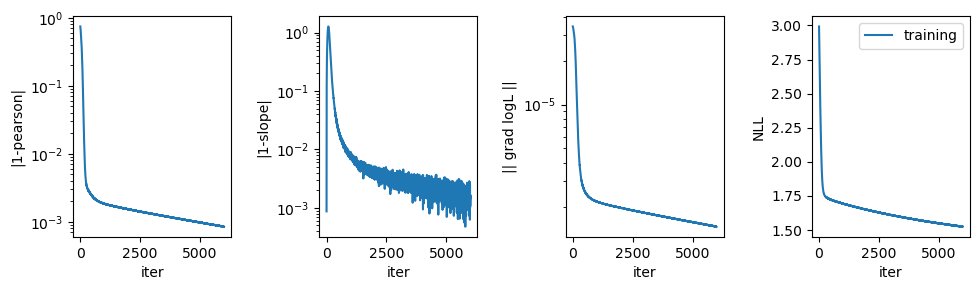

In [445]:
callbacks[0].plot();

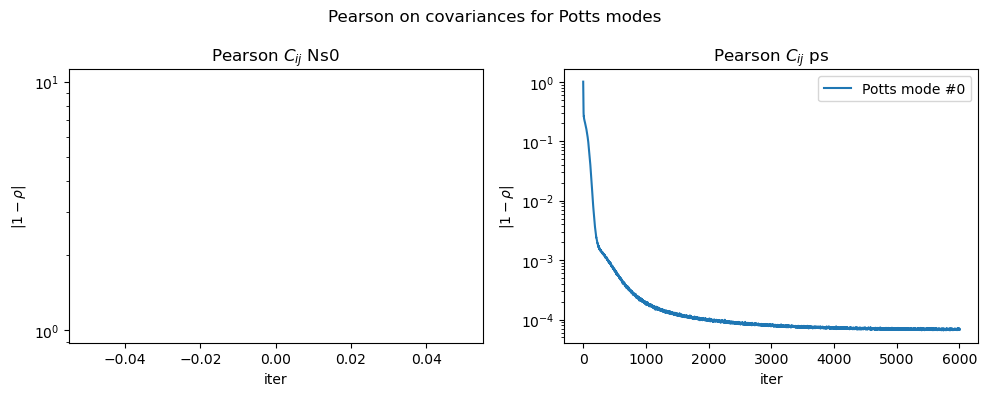

In [446]:
callbacks[1].plot();

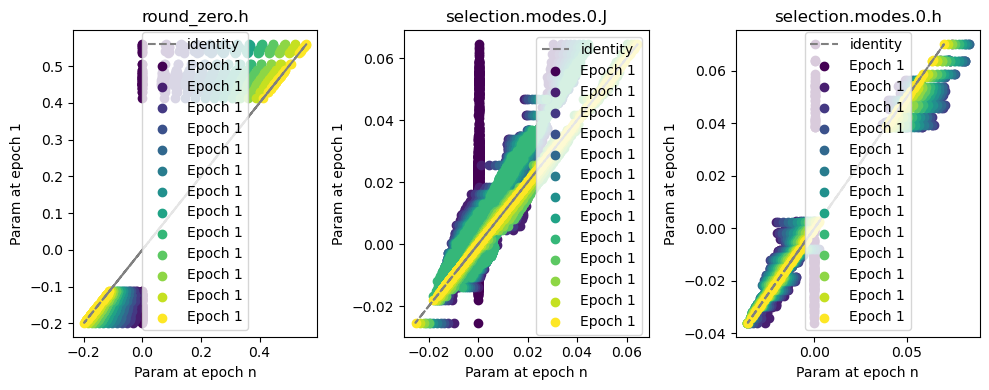

In [447]:
callbacks[-1].plot(plot_every=50);

In [ ]:
Js = list(zip(*callbacks[-1].params))[1]
norms = [torch.linalg.norm(J) for J in Js]
plt.plot(norms)

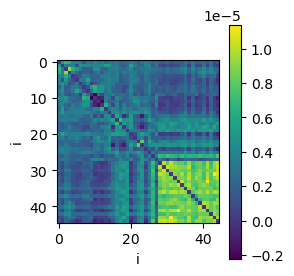

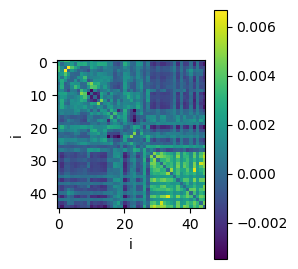

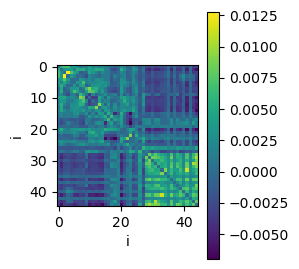

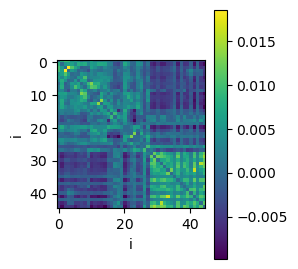

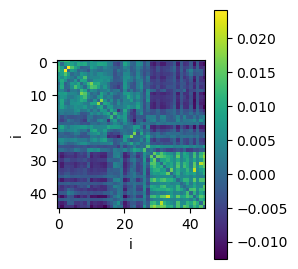

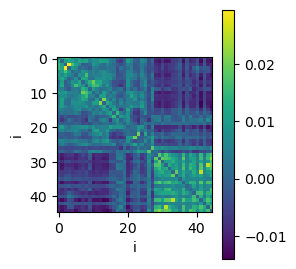

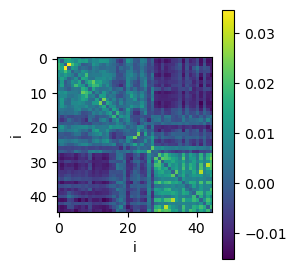

In [451]:
Fs = [selex_dca.get_contact_map(utils.zerosum_gauge_couplings(J)) for J in Js]
for n in range(0, len(Fs), 100):
    pl, ax = plt.subplots(figsize=(3,3))
    im = ax.imshow(Fs[n])
    ax.set_xlabel("i"); ax.set_ylabel("i")
    plt.colorbar(im)
    plt.tight_layout()

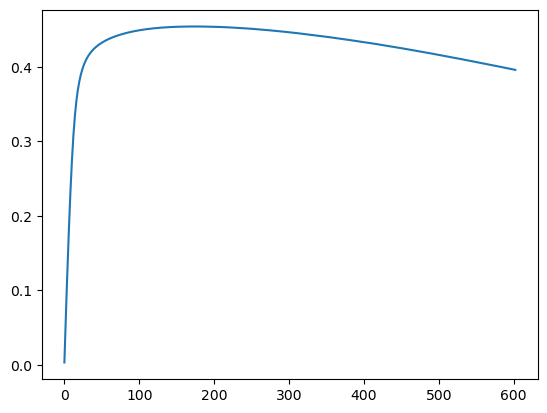

In [450]:
hs = list(zip(*callbacks[-1].params))[2]
norms = [torch.linalg.norm(h) for h in hs]
plt.plot(norms)

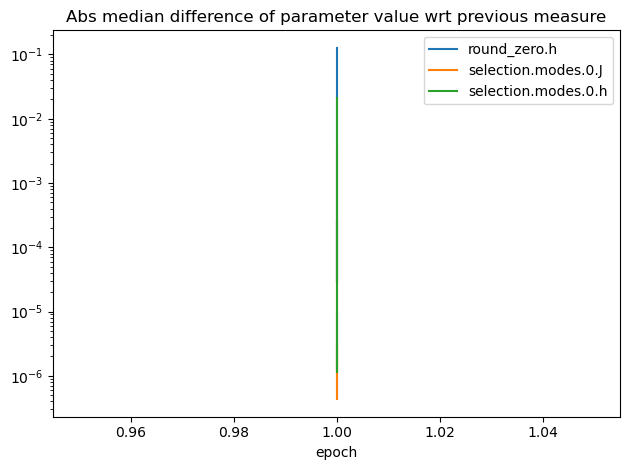

In [438]:
callbacks[-1].plot_diff();

<IPython.core.display.Latex object>

Multi-round


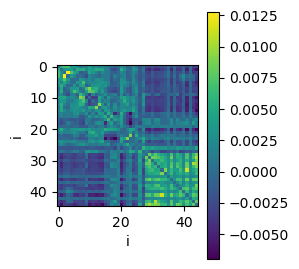

In [414]:
from IPython.display import display, Latex

potts_zerosum = potts.set_zerosum_gauge()
J = potts_zerosum.J.detach()
h = potts_zerosum.h.detach()

pl, ax = plt.subplots(figsize=(3,3))
F = selex_dca.get_contact_map(J)
im = ax.imshow(F)
ax.set_xlabel("i"); ax.set_ylabel("i")
plt.colorbar(im)
plt.tight_layout()
display(Latex("$F_{ij}=\\sqrt {\\sum_{ab}(J_{ij}^{ab})^2}$"))
print('Multi-round')

In [320]:
torch.save(model, f'saved/{experiment_id}.pt')

In [415]:
cps = training.load_checkpoints(checkpoint_filename)

Loaded 62 files.


In [416]:
Fs = []
Js = []
hs = []
for n in range(len(cps)):
    cp = cps[n]
    model_ = cp['model']
    potts_zerosum = model_.selection.modes[0].set_zerosum_gauge()
    J = potts_zerosum.J.detach()
    h = potts_zerosum.h.detach()
    F = selex_dca.get_contact_map(J)
    Fs.append(F)
    Js.append(J)
    hs.append(h)

/tmp/ipykernel_2272747/3192101322.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  pl, ax = plt.subplots(figsize=(3,3))


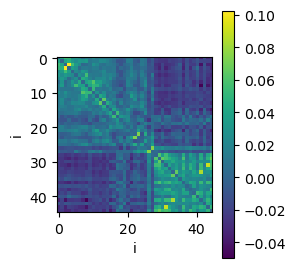

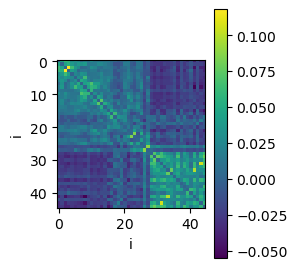

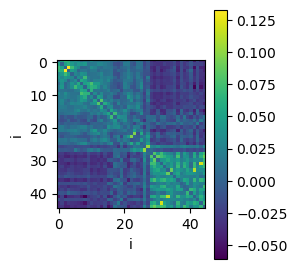

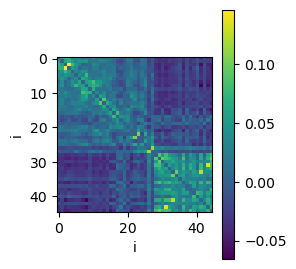

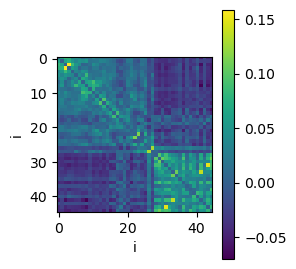

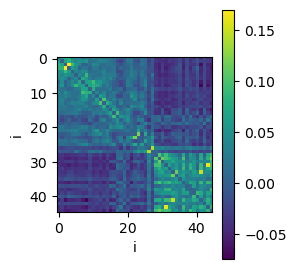

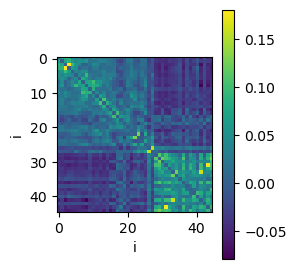

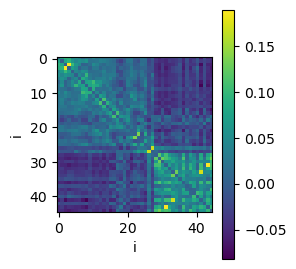

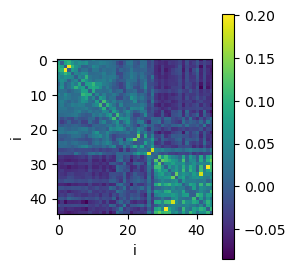

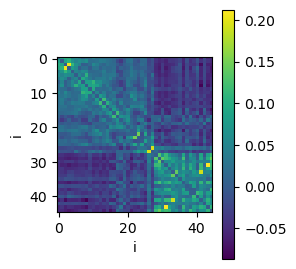

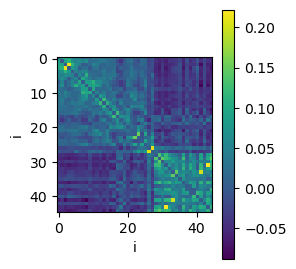

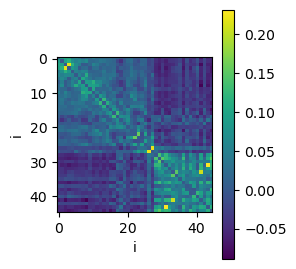

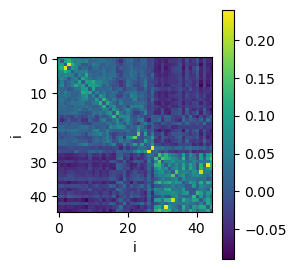

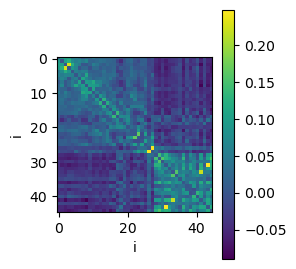

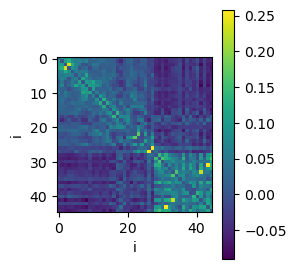

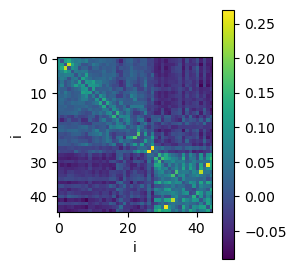

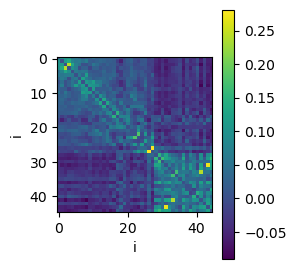

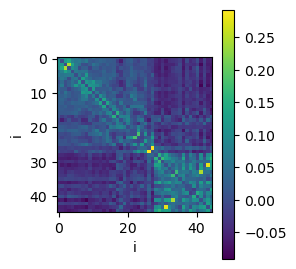

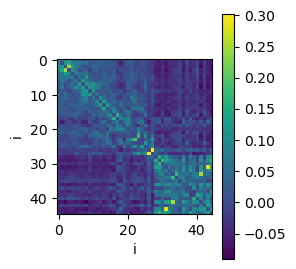

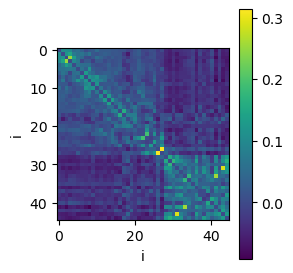

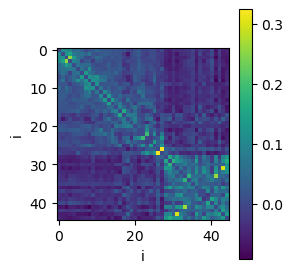

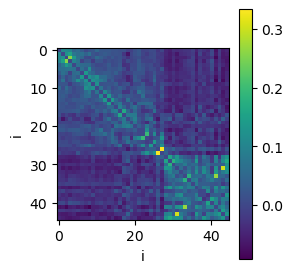

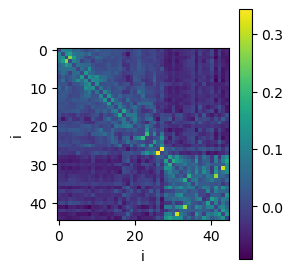

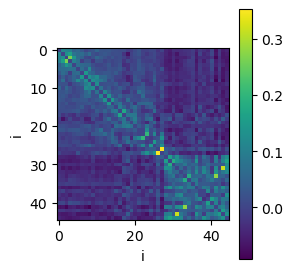

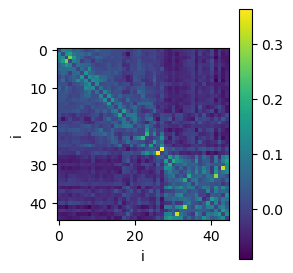

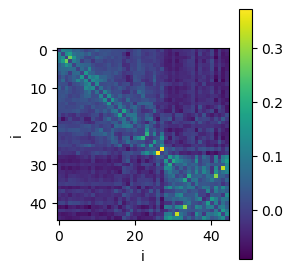

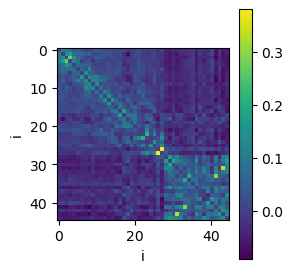

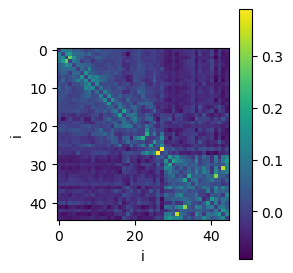

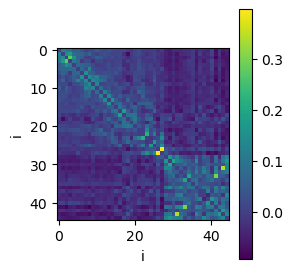

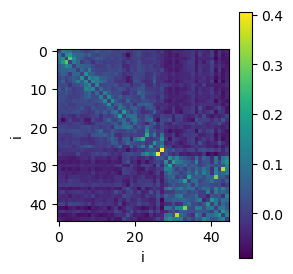

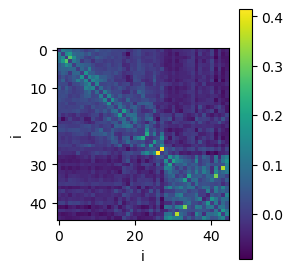

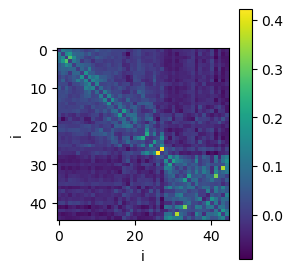

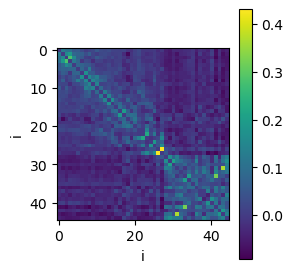

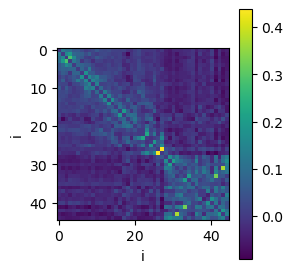

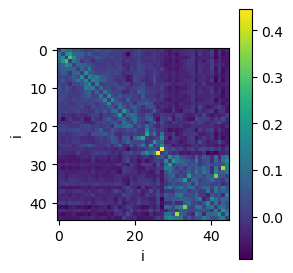

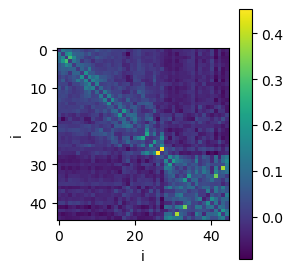

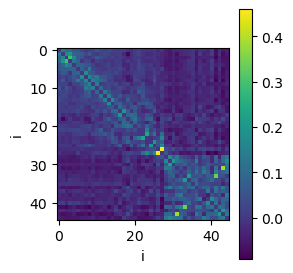

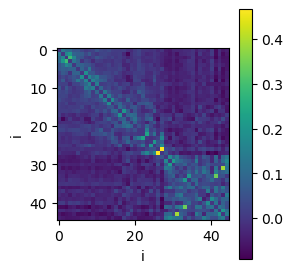

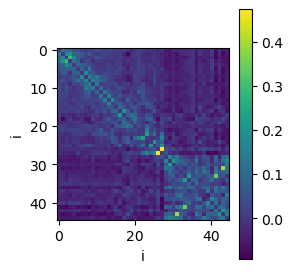

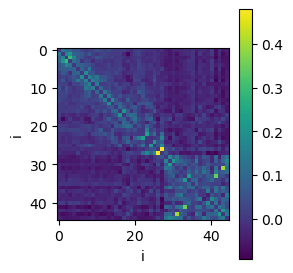

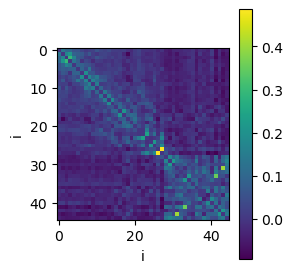

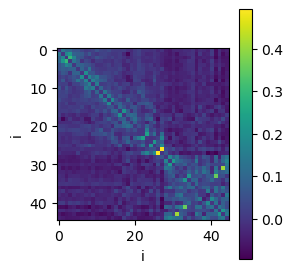

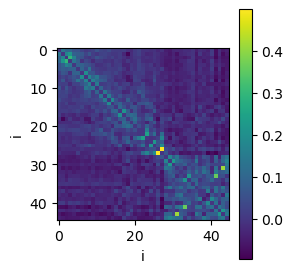

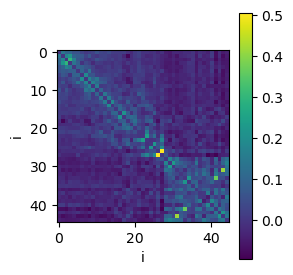

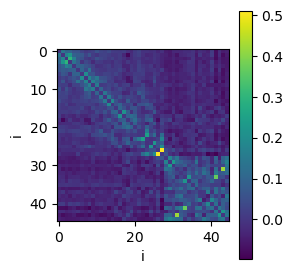

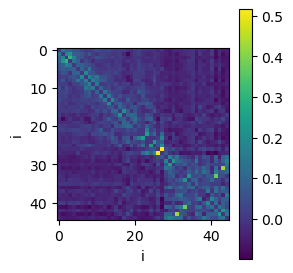

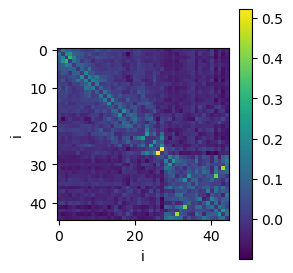

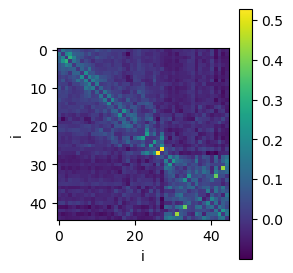

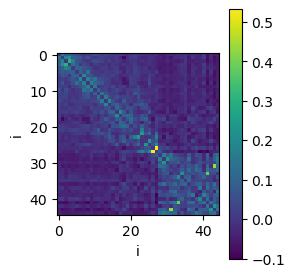

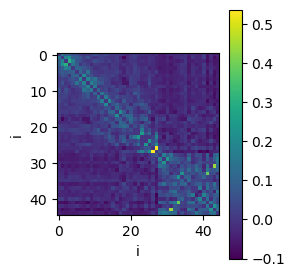

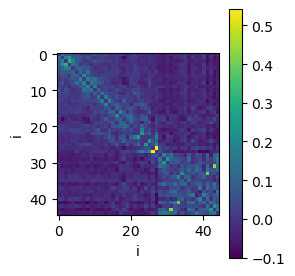

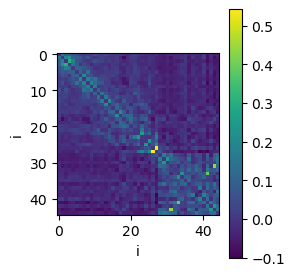

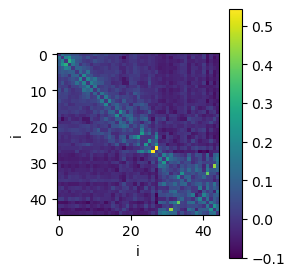

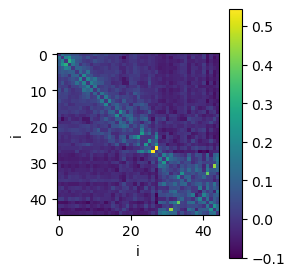

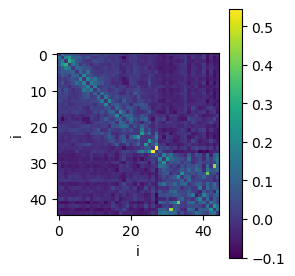

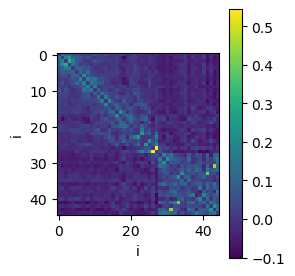

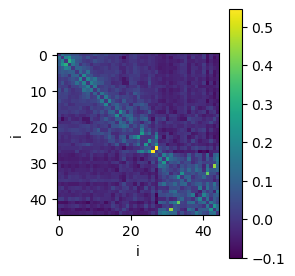

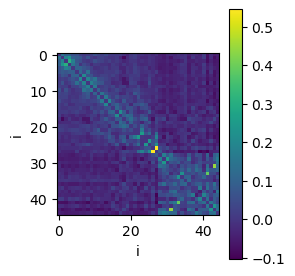

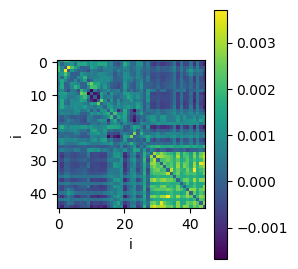

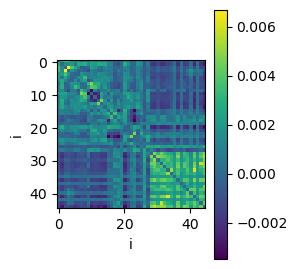

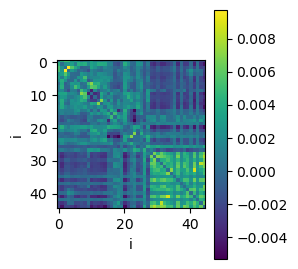

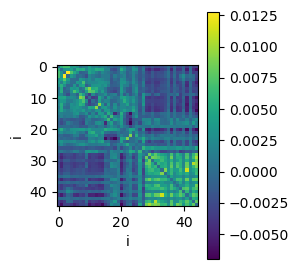

In [417]:
for n in range(len(cps)):
    pl, ax = plt.subplots(figsize=(3,3))
    im = ax.imshow(Fs[n])
    ax.set_xlabel("i"); ax.set_ylabel("i")
    plt.colorbar(im)
    plt.tight_layout()

/home/scrotti/Aptamer2025py/.pixi/envs/default/lib/python3.12/site-packages/IPython/core/events.py:96: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/scrotti/Aptamer2025py/.pixi/envs/default/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


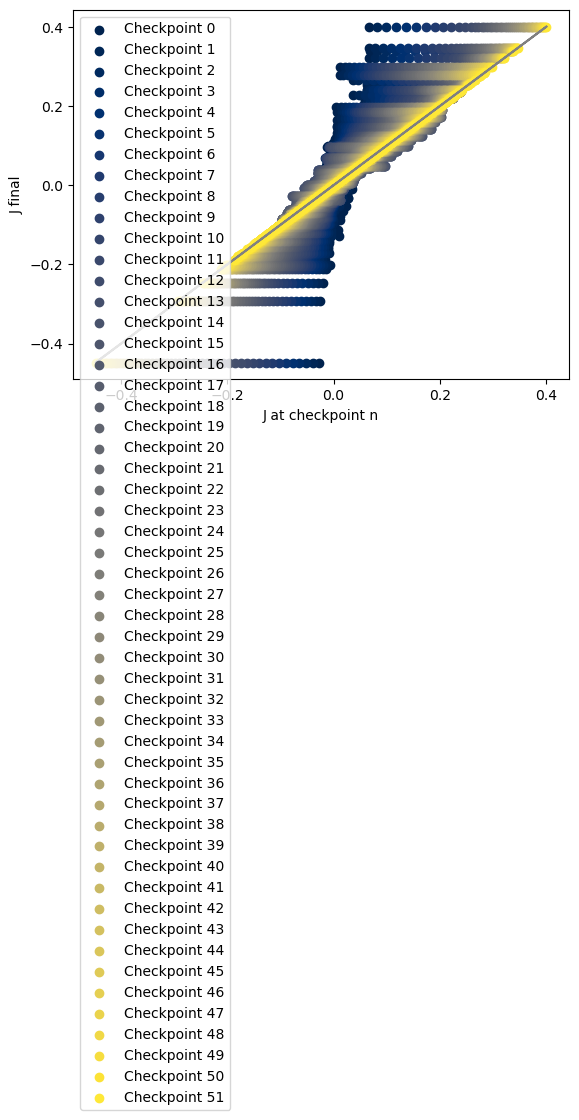

In [324]:
cgrad = [cm.cividis(x) for x in np.linspace(0, 1, len(cps))]
for n in range(len(cps)):
    plt.scatter(utils.off_diagonal_terms(Js[n]), utils.off_diagonal_terms(Js[-1]), 
                label=f'Checkpoint {n}', color=cgrad[n])

plt.plot(Js[-1].reshape(-1), Js[-1].reshape(-1), color='gray')
plt.xlabel('J at checkpoint n')
plt.ylabel('J final')
plt.legend()

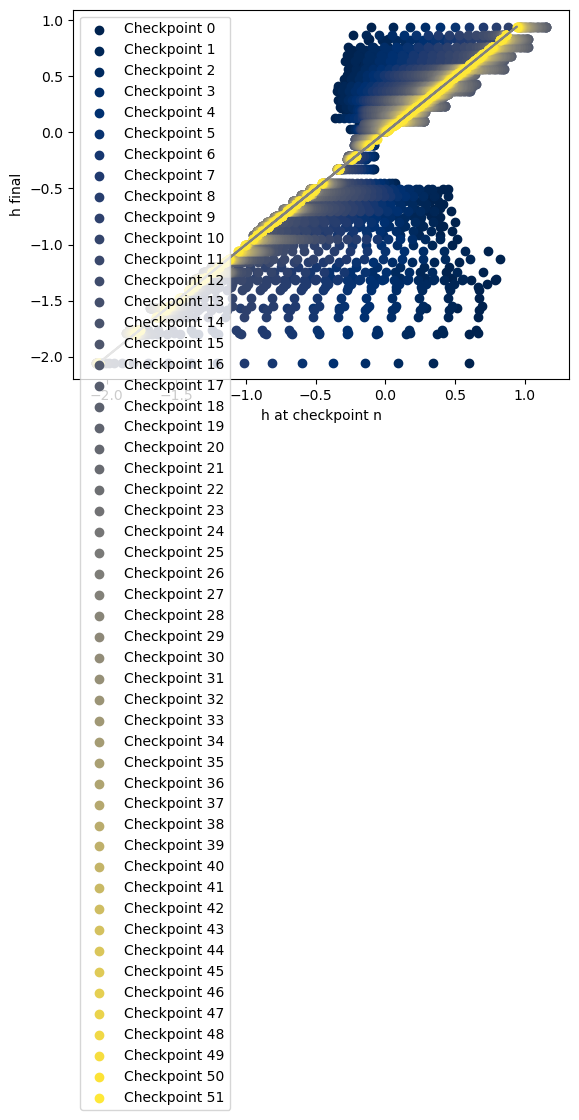

In [325]:
for n in range(len(cps)):
    plt.scatter(hs[n], hs[-1], label=f'Checkpoint {n}', color=cgrad[n])

plt.plot(hs[-1].reshape(-1), hs[-1].reshape(-1), color='gray')
plt.xlabel('h at checkpoint n')
plt.ylabel('h final')
plt.legend()